# Analyse de Balourd sur Souffleuse Sidel
Détection automatique à partir d'un codeur 36000 points/tour

Ce notebook analyse les données d'un codeur pour détecter la présence d'un balourd sur une roue en rotation.

## 1. Import des bibliothèques nécessaires

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

## 2. Paramètres de configuration

In [352]:
# Paramètres du codeur et de l'analyse
POINTS_PAR_TOUR = 36000  # Résolution du codeur

# Configuration de la machine Sidel
NOMBRE_STATIONS = 16  # Nombre de stations de soufflage (SBO20)
                      # Configurable selon la machine: 6, 8, 10, 12, 16, 20, 24, 28, 30, 34, etc.

NOMBRE_DENTS_COURONNE = 141  # Nombre de dents de la couronne d'entraînement
                             # Typique: GM -> Z=151 | MM -> Z=125 | LM -> Z=xxx

# Seuils de détection (à ajuster selon votre application)
SEUIL_VARIATION_VITESSE = 0.01  # 0.5% de variation pour détecter un balourd
SEUIL_AMPLITUDE_FFT = 0.01       # Amplitude minimale dans le spectre

# Spécifiez le chemin vers votre fichier CSV
FICHIER_CSV = './CSV/Machines/SBO16#110755/WHEEL_ValEncoder_eng.csv'  # Modifiez ce chemin selon votre fichier


## 3. Chargement et préparation des données

Rollover: Remise à zéro du compteur codeur après avoir atteint sa valeur maximale (35999→0)

In [353]:
def charger_donnees_sidel(fichier_csv):
    """
    Charge les données depuis le fichier CSV au format B&R CSV English
    Le fichier contient une ligne d'en-tête avec métadonnées
    puis les données temps,valeur_encodeur
    
    Paramètres:
    -----------
    fichier_csv : str
        Chemin vers le fichier CSV contenant les données
    
    Retourne:
    ---------
    DataFrame avec les colonnes temps et position du codeur
    """
    try:
        # Lecture du fichier en ignorant la première ligne (métadonnées)
        with open(fichier_csv, 'r') as f:
            lines = f.readlines()
        
        # Ignorer la ligne de métadonnées
        data_lines = []
        for line in lines[1:]:
            line = line.strip()
            if line and not line.startswith('%'):
                # Enlever la virgule finale si présente
                if line.endswith(','):
                    line = line[:-1]
                data_lines.append(line)
        
        # Créer le DataFrame
        data = []
        for line in data_lines:
            parts = line.split(',')
            if len(parts) >= 2:
                try:
                    time = float(parts[0])
                    encoder = float(parts[1])
                    data.append([time, encoder])
                except ValueError:
                    continue
        
        df = pd.DataFrame(data, columns=['temps', 'position_codeur'])
        
        print(f"✓ Données chargées: {len(df)} points")
        print(f"  Durée totale: {df['temps'].iloc[-1] - df['temps'].iloc[0]:.3f} secondes")
        print(f"  Fréquence d'échantillonnage: {1/(df['temps'].iloc[1] - df['temps'].iloc[0]):.1f} Hz")
        print(f"  Plage du codeur: {df['position_codeur'].min():.0f} - {df['position_codeur'].max():.0f}")
        
        # Détection et correction des sauts de codeur (rollover à 36000)
        df = corriger_rollover(df)
        
        return df
    
    except Exception as e:
        print(f"❌ Erreur lors du chargement: {e}")
        return None

def corriger_rollover(df):
    """
    Corrige les sauts du codeur quand il passe de 35999 à 0 (rollover)
    
    Rollover: Remise à zéro du compteur codeur après avoir atteint sa valeur maximale (35999→0)
    """
    position = df['position_codeur'].values.copy()
    position_corrigee = np.zeros_like(position)
    position_corrigee[0] = position[0]
    
    offset = 0
    for i in range(1, len(position)):
        diff = position[i] - position[i-1]
        
        # Détection d'un rollover négatif (35999 -> 0)
        if diff < -30000:
            offset += POINTS_PAR_TOUR
        # Détection d'un rollover positif (0 -> 35999)
        elif diff > 30000:
            offset -= POINTS_PAR_TOUR
        
        position_corrigee[i] = position[i] + offset
    
    df['position_corrigee'] = position_corrigee
    
    # Calcul du nombre de tours effectués
    tours_effectues = (position_corrigee[-1] - position_corrigee[0]) / POINTS_PAR_TOUR
    print(f"  Tours effectués: {tours_effectues:.2f}")
    
    # Visualisation de l'évolution de la position du codeur
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Graphique 1: Position brute du codeur
    ax1.plot(df['temps'], df['position_codeur'], 'b-', linewidth=0.5)
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Position codeur brute (points)')
    ax1.set_title('Position brute du codeur (avec rollovers)')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-1000, 37000)
    
    # Ajout de lignes pour marquer les limites du codeur
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Limite basse (0)')
    ax1.axhline(y=35999, color='r', linestyle='--', alpha=0.5, label='Limite haute (35999)')
    ax1.legend(loc='upper right')
    
    # Graphique 2: Position corrigée (cumulative)
    ax2.plot(df['temps'], position_corrigee, 'g-', linewidth=0.5)
    ax2.set_xlabel('Temps (s)')
    ax2.set_ylabel('Position corrigée cumulative (points)')
    ax2.set_title(f'Position corrigée du codeur - {tours_effectues:.2f} tours effectués')
    ax2.grid(True, alpha=0.3)
    
    # Ajout de lignes horizontales pour marquer chaque tour complet
    for i in range(int(tours_effectues) + 1):
        y_tour = position_corrigee[0] + i * POINTS_PAR_TOUR
        ax2.axhline(y=y_tour, color='orange', linestyle=':', alpha=0.5)
        if i <= 5:  # Limiter l'annotation aux 5 premiers tours pour la lisibilité
            ax2.text(df['temps'].iloc[-1] * 0.98, y_tour, f'Tour {i}', 
                    verticalalignment='bottom', fontsize=8)
    
    # Calcul et affichage de la vitesse de rotation moyenne
    vitesse_rotation_moyenne = tours_effectues / (df['temps'].iloc[-1] - df['temps'].iloc[0])
    duree_moyenne_tour = (df['temps'].iloc[-1] - df['temps'].iloc[0]) / tours_effectues if tours_effectues > 0 else 0
    
    ax2.text(0.02, 0.98, f'Vitesse moyenne: {vitesse_rotation_moyenne:.2f} tours/s ({vitesse_rotation_moyenne*60:.1f} RPM)\nDurée moyenne par tour: {duree_moyenne_tour:.2f} s',
            transform=ax2.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"  Vitesse de rotation moyenne: {vitesse_rotation_moyenne:.2f} tours/s ({vitesse_rotation_moyenne*60:.1f} RPM)")
    print(f"  Durée moyenne par tour: {duree_moyenne_tour:.2f} secondes")
    
    return df

## 4. Chargement des données réelles

✓ Données chargées: 32767 points
  Durée totale: 39.319 secondes
  Fréquence d'échantillonnage: 837.5 Hz
  Plage du codeur: 0 - 35999
  Tours effectués: 14.37


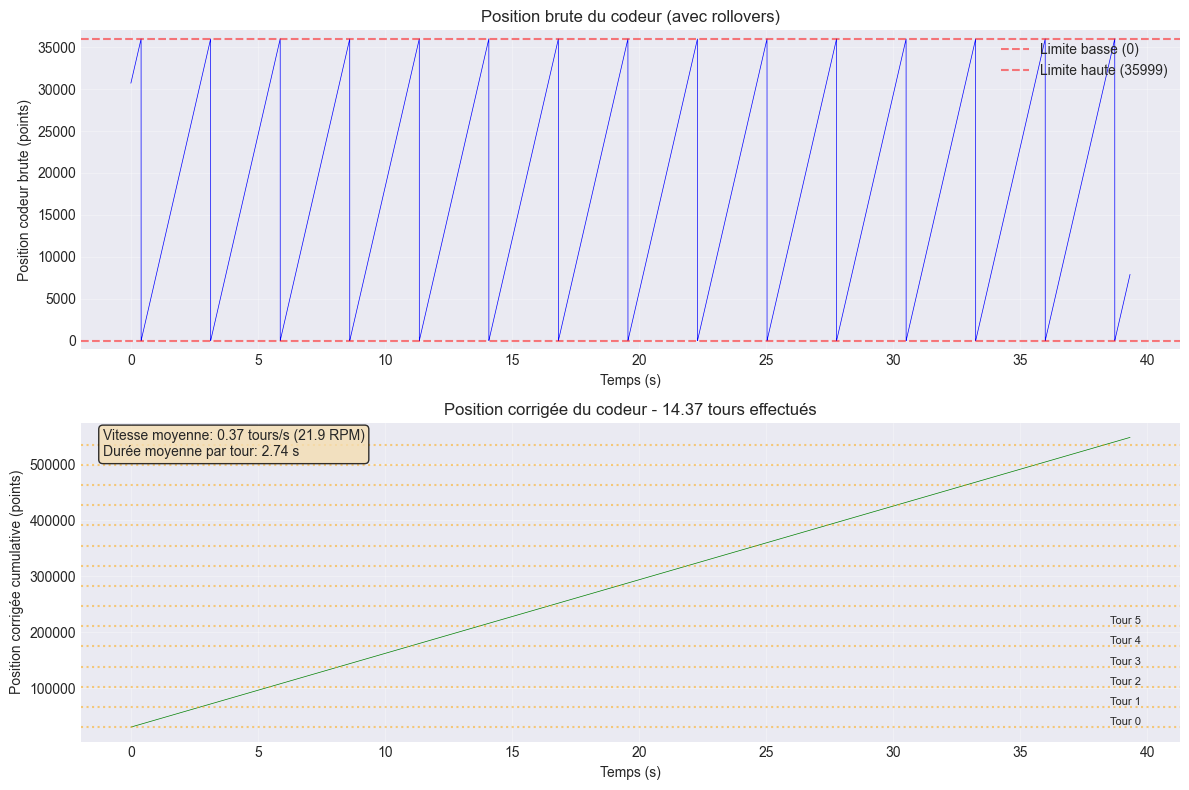

  Vitesse de rotation moyenne: 0.37 tours/s (21.9 RPM)
  Durée moyenne par tour: 2.74 secondes


In [354]:
# Chargement du fichier CSV
df = charger_donnees_sidel(FICHIER_CSV)

if df is None:
    print("\n" + "="*60)
    print("❌ ERREUR: Impossible de charger le fichier")
    print("="*60)
    print(f"Vérifiez que le fichier '{FICHIER_CSV}' existe dans le bon répertoire.")
    print("Si votre fichier a un nom différent, modifiez la variable FICHIER_CSV.")
    print("\nExemples de chemins valides:")
    print("  • 'WHEEL_ValEncoder_eng.csv' (même dossier que le notebook)")
    print("  • './data/WHEEL_ValEncoder_eng.csv' (sous-dossier 'data')")
    print("  • '../WHEEL_ValEncoder_eng.csv' (dossier parent)")
    raise FileNotFoundError(f"Le fichier '{FICHIER_CSV}' n'a pas été trouvé. Arrêt de l'analyse.")

## 5. Calcul de la vitesse instantanée et analyse

Le filtre Butterworth lisse le signal en supprimant les vibrations parasites tout en conservant les variations importantes liées au balourd
Ce filtre agit comme un 'lisseur' qui garde les variations lentes (balourd) et supprime les variations rapides (bruit de mesure, vibrations mécaniques)

  ⚠️ Correction des artefacts de bord : 32 points aux extrémités

✓ Vitesse instantanée calculée
  Vitesse moyenne: 13159.4 points/seconde
  Variation max: 1.319%
  Écart-type des variations: 0.242%


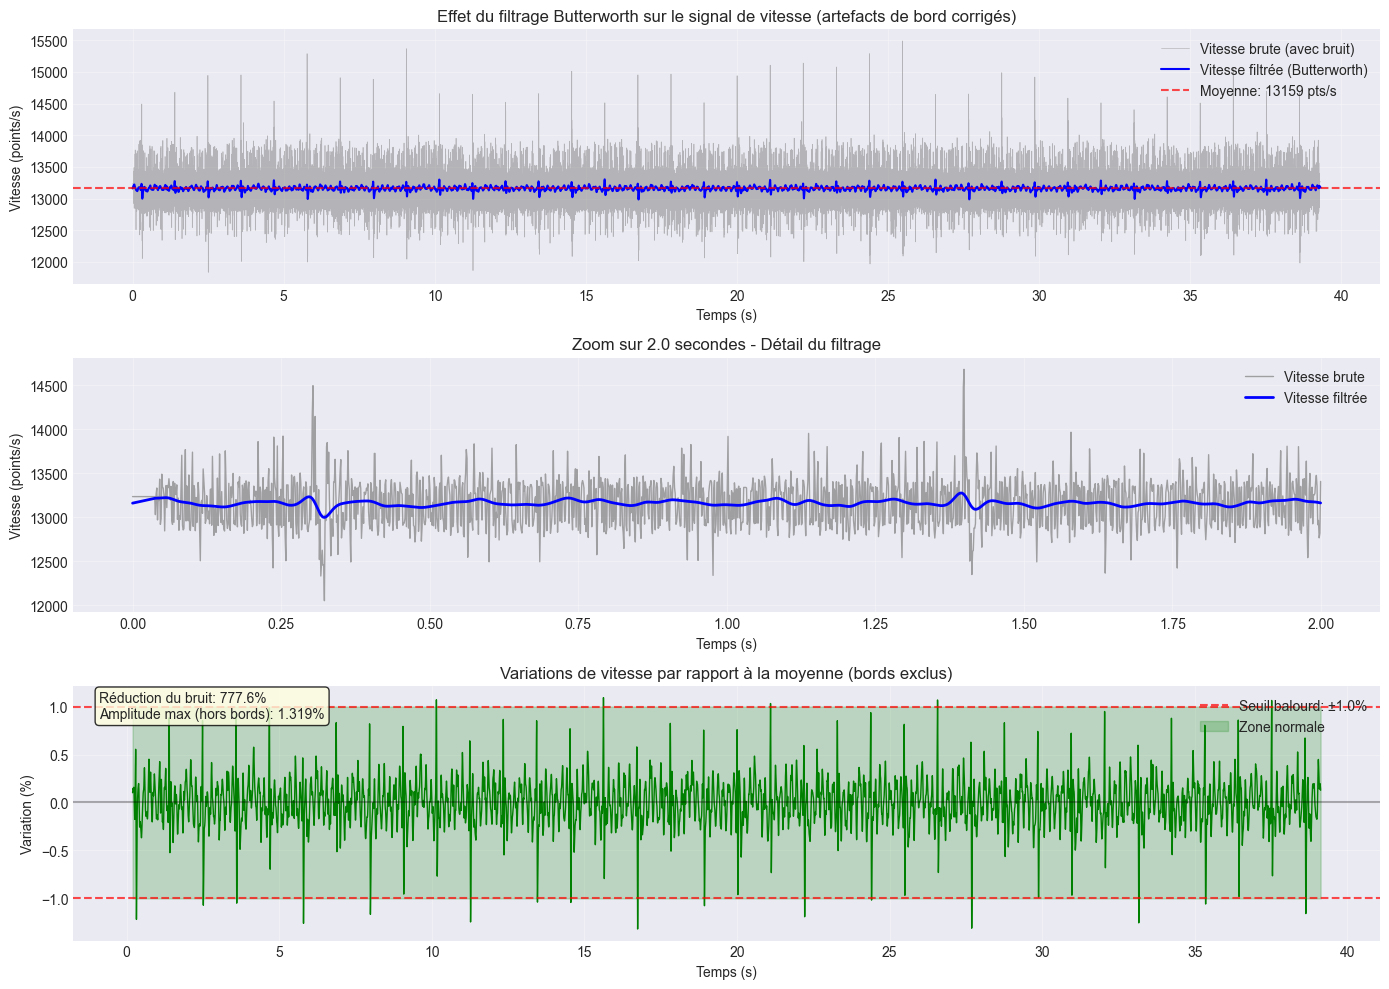

In [355]:
def calculer_vitesse_instantanee(df):
    """
    Calcule la vitesse instantanée à partir de la position du codeur
    """
    # Utiliser la position corrigée pour éviter les discontinuités
    position = df['position_corrigee'].values
    temps = df['temps'].values
    
    # Calcul de la vitesse instantanée (dérivée de la position)
    vitesse_brute = np.gradient(position, temps)
    
    # CORRECTION DES ARTEFACTS DE BORD
    # On exclut les premiers et derniers points (typiquement 0.5% des données)
    n_points_exclus = max(10, int(len(vitesse_brute) * 0.001))  # 0.1% ou minimum 10 points
    
    # Remplacement des valeurs aux extrémités par la médiane locale
    vitesse_brute[:n_points_exclus] = np.median(vitesse_brute[n_points_exclus:n_points_exclus*3])
    vitesse_brute[-n_points_exclus:] = np.median(vitesse_brute[-n_points_exclus*3:-n_points_exclus])
    
    # Filtrage passe-bas pour éliminer le bruit haute fréquence
    # Le filtre Butterworth lisse le signal en supprimant les vibrations parasites
    # tout en conservant les variations importantes liées au balourd
    freq_echantillonnage = 1 / (temps[1] - temps[0])
    freq_coupure = 20  # Hz - fréquence au-delà de laquelle on considère que c'est du bruit
    
    # Conception du filtre Butterworth d'ordre 3
    # Ce filtre agit comme un "lisseur" qui garde les variations lentes (balourd)
    # et supprime les variations rapides (bruit de mesure, vibrations mécaniques)
    b, a = signal.butter(3, freq_coupure / (freq_echantillonnage / 2), 'low')
    
    # Application du filtre
    vitesse_filtree = signal.filtfilt(b, a, vitesse_brute)
    
    # DEUXIÈME CORRECTION : Forcer les extrémités à la moyenne locale
    vitesse_moyenne_debut = np.mean(vitesse_filtree[n_points_exclus:n_points_exclus*5])
    vitesse_moyenne_fin = np.mean(vitesse_filtree[-n_points_exclus*5:-n_points_exclus])
    
    # Lissage progressif aux extrémités
    for i in range(n_points_exclus):
        # Début : transition progressive vers la moyenne locale
        factor = i / n_points_exclus
        vitesse_filtree[i] = vitesse_moyenne_debut * (1 - factor) + vitesse_filtree[n_points_exclus] * factor
        
        # Fin : transition progressive depuis la moyenne locale
        vitesse_filtree[-(i+1)] = vitesse_moyenne_fin * (1 - factor) + vitesse_filtree[-(n_points_exclus+1)] * factor
    
    print(f"  ⚠️ Correction des artefacts de bord : {n_points_exclus} points aux extrémités")
    
    # Ajout au DataFrame
    df['vitesse_brute'] = vitesse_brute
    df['vitesse_filtree'] = vitesse_filtree
    
    # Calcul de la vitesse moyenne et des variations
    vitesse_moyenne = vitesse_filtree.mean()
    df['variation_vitesse'] = (vitesse_filtree - vitesse_moyenne) / vitesse_moyenne
    
    print(f"\n✓ Vitesse instantanée calculée")
    print(f"  Vitesse moyenne: {vitesse_moyenne:.1f} points/seconde")
    print(f"  Variation max: {df['variation_vitesse'].abs().max()*100:.3f}%")
    print(f"  Écart-type des variations: {df['variation_vitesse'].std()*100:.3f}%")
    
    # Visualisation de l'effet du filtrage
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
    
    # Graphique 1: Comparaison vitesse brute vs filtrée (vue complète)
    ax1.plot(df['temps'], vitesse_brute, 'gray', alpha=0.5, linewidth=0.5, label='Vitesse brute (avec bruit)')
    ax1.plot(df['temps'], vitesse_filtree, 'b-', linewidth=1.5, label='Vitesse filtrée (Butterworth)')
    ax1.axhline(y=vitesse_moyenne, color='r', linestyle='--', alpha=0.7, 
                label=f'Moyenne: {vitesse_moyenne:.0f} pts/s')
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Vitesse (points/s)')
    ax1.set_title('Effet du filtrage Butterworth sur le signal de vitesse (artefacts de bord corrigés)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Zoom sur 2 secondes pour voir le détail
    temps_zoom = 2.0  # Zoom sur les 2 premières secondes
    mask_zoom = df['temps'] <= temps_zoom
    ax2.plot(df['temps'][mask_zoom], vitesse_brute[mask_zoom], 'gray', alpha=0.7, 
             linewidth=1, label='Vitesse brute')
    ax2.plot(df['temps'][mask_zoom], vitesse_filtree[mask_zoom], 'b-', 
             linewidth=2, label='Vitesse filtrée')
    ax2.set_xlabel('Temps (s)')
    ax2.set_ylabel('Vitesse (points/s)')
    ax2.set_title(f'Zoom sur {temps_zoom} secondes - Détail du filtrage')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Graphique 3: Variations en pourcentage (signal filtré)
    # On exclut les zones de bord pour une meilleure visualisation
    n_exclus = max(10, int(len(df) * 0.005))
    temps_clean = df['temps'].iloc[n_exclus:-n_exclus]
    variation_clean = df['variation_vitesse'].iloc[n_exclus:-n_exclus]
    
    ax3.plot(temps_clean, variation_clean*100, 'g-', linewidth=1)
    ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax3.axhline(y=SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--', alpha=0.7, 
                label=f'Seuil balourd: ±{SEUIL_VARIATION_VITESSE*100:.1f}%')
    ax3.axhline(y=-SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--', alpha=0.7)
    ax3.fill_between(temps_clean, -SEUIL_VARIATION_VITESSE*100, SEUIL_VARIATION_VITESSE*100, 
                     alpha=0.2, color='green', label='Zone normale')
    ax3.set_xlabel('Temps (s)')
    ax3.set_ylabel('Variation (%)')
    ax3.set_title('Variations de vitesse par rapport à la moyenne (bords exclus)')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    # Ajout d'informations statistiques
    ax3.text(0.02, 0.98, 
            f'Réduction du bruit: {(vitesse_brute[n_exclus:-n_exclus].std()/vitesse_filtree[n_exclus:-n_exclus].std() - 1)*100:.1f}%\n' +
            f'Amplitude max (hors bords): {variation_clean.abs().max()*100:.3f}%',
            transform=ax3.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return df

df = calculer_vitesse_instantanee(df)

## 6. Analyse fréquentielle (FFT)
La FFT (Fast Fourier Transform) décompose notre signal en ses différentes fréquences de vibration.
Un balourd crée une vibration périodique à la fréquence de rotation de la roue.
Si on détecte un pic dominant à cette fréquence, c'est un signe fort de balourd.

En termes simples :

La FFT est comme un "analyseur de sons" qui identifie toutes les fréquences présentes dans le signal
Un balourd fait vibrer la roue 1 fois par tour (comme une machine à laver déséquilibrée)
Si on trouve cette fréquence caractéristique dans l'analyse, on a probablement un balourd


✓ Analyse FFT effectuée
  Fréquence de rotation calculée: 0.365 Hz (21.9 RPM)
  Fréquence d'engrènement couronne (141 dents): 51.5 Hz
  Nombre de pics significatifs: 0

  Création des graphiques FFT...
  Fréquence de rotation pour les marqueurs: 0.365 Hz
  Ajout des marqueurs de tours (freq=0.365 Hz)...
  Marquage de 14 tours (période=2.74s)


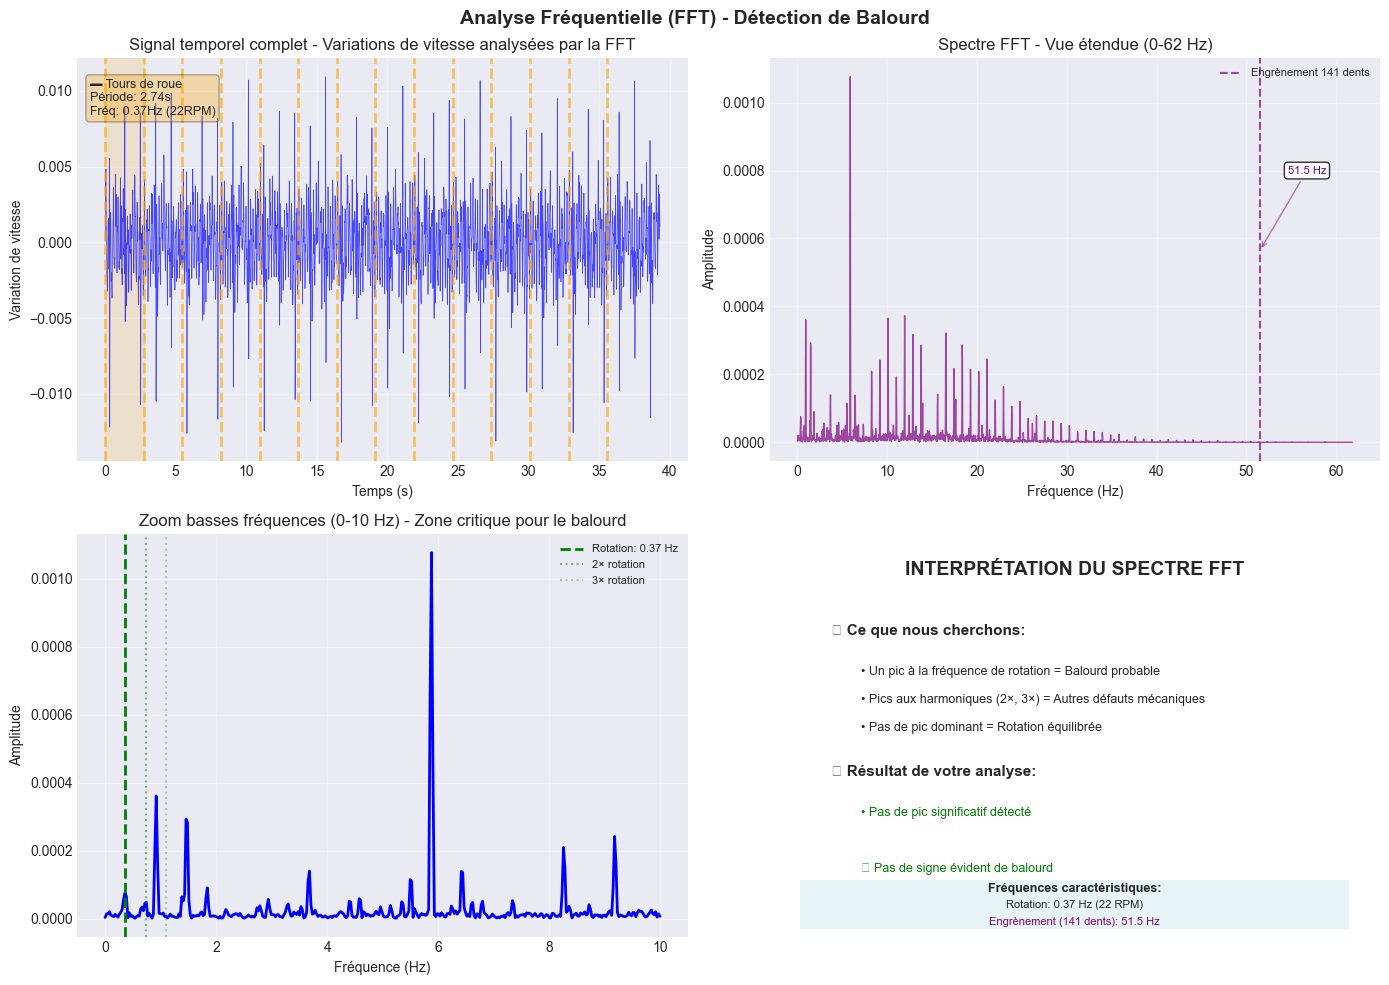


📖 GUIDE DE LECTURE DES GRAPHIQUES FFT

🎯 COMMENT INTERPRÉTER CES GRAPHIQUES :

1️⃣ SIGNAL TEMPOREL (en haut à gauche)
   • Montre les variations de vitesse dans le temps
   • Lignes orange = Marqueurs de tours complets
   • Si régulier = rotation stable

2️⃣ SPECTRE FFT COMPLET (en haut à droite)
   • Panorama de toutes les vibrations détectées
   • Plus le pic est haut = plus la vibration est forte

3️⃣ ZOOM BASSES FRÉQUENCES (en bas à gauche) ⭐ LE PLUS IMPORTANT
   • Zone critique pour détecter le balourd
   • 🟢 Ligne verte continue = Fréquence de rotation de votre roue
   • 🔴 Points rouges = Pics de vibration détectés
   • Si un point rouge est sur la ligne verte = BALOURD !

📊 DIAGNOSTIC RAPIDE :
   ✅ PAS DE BALOURD si : Pas de pic rouge sur la ligne verte
   ⚠️ BALOURD DÉTECTÉ si : Gros pic rouge sur ou près de la ligne verte
   🔧 AUTRES PROBLÈMES si : Pics sur les lignes pointillées (2×, 3× rotation)

💡 ASTUCE : Un balourd fait vibrer la machine 1 fois par tour,
           comme

In [356]:
def analyse_fft_complete(df):
    """
    Effectue une analyse FFT détaillée pour identifier les fréquences dominantes
    """
    # Signal à analyser (variations de vitesse)
    signal_vitesse = df['variation_vitesse'].values
    temps = df['temps'].values
    
    # Paramètres FFT
    N = len(signal_vitesse)
    dt = temps[1] - temps[0]
    
    # Application d'une fenêtre de Hanning pour réduire les effets de bord
    window = np.hanning(N)
    signal_windowed = signal_vitesse * window
    
    # FFT
    yf = fft(signal_windowed)
    xf = fftfreq(N, dt)[:N//2]
    amplitudes = 2.0/N * np.abs(yf[:N//2])
    
    # Recherche des pics principaux
    peaks, properties = find_peaks(amplitudes[1:], height=SEUIL_AMPLITUDE_FFT)
    peaks = peaks + 1  # Correction de l'indice (on avait ignoré le DC)
    
    # Calcul de la fréquence de rotation estimée EN PREMIER
    duree_totale = temps[-1] - temps[0]
    tours_effectues = (df['position_corrigee'].iloc[-1] - df['position_corrigee'].iloc[0]) / POINTS_PAR_TOUR
    freq_rotation_estimee = tours_effectues / duree_totale if duree_totale > 0 else 0
    
    # Calcul de la fréquence d'engrènement de la couronne
    freq_engrenement = freq_rotation_estimee * NOMBRE_DENTS_COURONNE
    
    print(f"\n✓ Analyse FFT effectuée")
    print(f"  Fréquence de rotation calculée: {freq_rotation_estimee:.3f} Hz ({freq_rotation_estimee*60:.1f} RPM)")
    print(f"  Fréquence d'engrènement couronne ({NOMBRE_DENTS_COURONNE} dents): {freq_engrenement:.1f} Hz")
    print(f"  Nombre de pics significatifs: {len(peaks)}")
    
    if len(peaks) > 0:
        # Tri des pics par amplitude
        sorted_peaks = sorted(peaks, key=lambda x: amplitudes[x], reverse=True)
        
        print("\n  Fréquences principales détectées:")
        for i, peak_idx in enumerate(sorted_peaks[:5]):  # Top 5 fréquences
            freq = xf[peak_idx]
            amp = amplitudes[peak_idx]
            print(f"    {i+1}. {freq:.3f} Hz (amplitude: {amp:.4f})")
        
        # Vérification si une fréquence correspond à la rotation
        freq_dominante = xf[sorted_peaks[0]]
        ratio = freq_dominante / freq_rotation_estimee if freq_rotation_estimee > 0 else 0
        
        if 0.8 < ratio < 1.2:
            print(f"  ⚠️ Fréquence dominante proche de 1× rotation (ratio: {ratio:.2f})")
            balourd_probable = True
        else:
            balourd_probable = False
    else:
        sorted_peaks = []
        freq_dominante = 0
        balourd_probable = False
    
    # === VISUALISATION DES RÉSULTATS FFT ===
    print(f"\n  Création des graphiques FFT...")
    print(f"  Fréquence de rotation pour les marqueurs: {freq_rotation_estimee:.3f} Hz")
    
    # Visualisation des résultats FFT
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Graphique 1: Signal temporel analysé (toute la durée)
    ax1.plot(temps, signal_vitesse, 'b-', linewidth=0.5, alpha=0.7)
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Variation de vitesse')
    ax1.set_title('Signal temporel complet - Variations de vitesse analysées par la FFT')
    ax1.grid(True, alpha=0.3)
    
    # Marquer les périodes de rotation
    print(f"  Ajout des marqueurs de tours (freq={freq_rotation_estimee:.3f} Hz)...")
    if freq_rotation_estimee > 0:
        periode_rotation = 1 / freq_rotation_estimee
        nb_tours_a_marquer = min(20, int(temps[-1] / periode_rotation))
        print(f"  Marquage de {nb_tours_a_marquer} tours (période={periode_rotation:.2f}s)")
        
        for i in range(nb_tours_a_marquer):
            t_tour = i * periode_rotation
            if t_tour <= temps[-1]:
                ax1.axvline(x=t_tour, color='orange', linestyle='--', alpha=0.6, linewidth=2)
        
        # Ajouter une bande colorée pour le premier tour
        if periode_rotation <= temps[-1]:
            ax1.axvspan(0, periode_rotation, alpha=0.15, color='orange')
        
        # Ajouter la légende
        ax1.text(0.02, 0.95, 
                f'▬ Tours de roue\nPériode: {periode_rotation:.2f}s\nFréq: {freq_rotation_estimee:.2f}Hz ({freq_rotation_estimee*60:.0f}RPM)', 
                transform=ax1.transAxes, verticalalignment='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
    else:
        print("  ⚠️ Pas de marqueurs de tours (fréquence de rotation = 0)")
    
    # Graphique 2: Spectre FFT complet avec zone étendue pour voir l'engrènement
    # Déterminer la plage d'affichage selon la fréquence d'engrènement
    max_freq_affichage = min(max(freq_engrenement * 1.2, 50), len(xf)//4)
    mask_display = xf < max_freq_affichage
    
    ax2.plot(xf[mask_display], amplitudes[mask_display], 'purple', linewidth=1, alpha=0.7)
    
    # Marquer la fréquence d'engrènement si elle est dans la plage
    if freq_engrenement > 0 and freq_engrenement < max_freq_affichage:
        ax2.axvline(x=freq_engrenement, color='purple', linestyle='--', 
                   linewidth=1.5, alpha=0.7, label=f'Engrènement {NOMBRE_DENTS_COURONNE} dents')
        # Ajouter une annotation décalée pour éviter la superposition
        y_max = ax2.get_ylim()[1]
        ax2.annotate(f'{freq_engrenement:.1f} Hz', 
                    xy=(freq_engrenement, y_max * 0.5),
                    xytext=(freq_engrenement + max_freq_affichage * 0.05, y_max * 0.7),
                    arrowprops=dict(arrowstyle='->', color='purple', alpha=0.5),
                    fontsize=8, color='purple',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax2.set_xlabel('Fréquence (Hz)')
    ax2.set_ylabel('Amplitude')
    ax2.set_title(f'Spectre FFT - Vue étendue (0-{max_freq_affichage:.0f} Hz)')
    if freq_engrenement > 0 and freq_engrenement < max_freq_affichage:
        ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # Graphique 3: Zoom sur les basses fréquences (0-10 Hz)
    mask_zoom = xf < 10
    ax3.plot(xf[mask_zoom], amplitudes[mask_zoom], 'b-', linewidth=2)
    
    # Marquer les pics détectés
    peaks_zoom = peaks[peaks < np.sum(mask_zoom)]
    if len(peaks_zoom) > 0:
        ax3.plot(xf[peaks_zoom], amplitudes[peaks_zoom], 'ro', markersize=10, label='Pics détectés')
        
        # Annoter les 3 premiers pics
        for i, peak in enumerate(peaks_zoom[:3]):
            ax3.annotate(f'{xf[peak]:.2f} Hz', 
                        xy=(xf[peak], amplitudes[peak]),
                        xytext=(10, 10 + i*15), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                        fontsize=9)
    
    # Marquer la fréquence de rotation théorique
    if freq_rotation_estimee > 0:
        ax3.axvline(x=freq_rotation_estimee, color='green', linestyle='--', 
                   linewidth=2, label=f'Rotation: {freq_rotation_estimee:.2f} Hz')
        # Marquer les harmoniques de rotation (2×, 3×)
        ax3.axvline(x=freq_rotation_estimee*2, color='green', linestyle=':', 
                   alpha=0.5, label=f'2× rotation')
        ax3.axvline(x=freq_rotation_estimee*3, color='green', linestyle=':', 
                   alpha=0.3, label=f'3× rotation')
    
    # Marquer la fréquence d'engrènement de la couronne (si visible dans la plage)
    if freq_engrenement > 0 and freq_engrenement < 10:
        ax3.axvline(x=freq_engrenement, color='purple', linestyle='--', 
                   linewidth=2, label=f'Engrènement: {freq_engrenement:.1f} Hz')
        # Identifier si un pic correspond à l'engrènement
        for peak in peaks_zoom:
            if abs(xf[peak] - freq_engrenement) < 0.5:  # Tolérance de 0.5 Hz
                ax3.annotate(f'Jeu denture?', 
                           xy=(xf[peak], amplitudes[peak]),
                           xytext=(-30, 20), textcoords='offset points',
                           arrowprops=dict(arrowstyle='->', color='purple', alpha=0.7),
                           fontsize=9, color='purple', fontweight='bold')
    
    ax3.set_xlabel('Fréquence (Hz)')
    ax3.set_ylabel('Amplitude')
    ax3.set_title('Zoom basses fréquences (0-10 Hz) - Zone critique pour le balourd')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # Graphique 4: Interprétation visuelle
    ax4.axis('off')
    
    # Créer une représentation schématique avec espacement vertical approprié
    y_pos = 0.90
    ax4.text(0.5, y_pos, 'INTERPRÉTATION DU SPECTRE FFT', 
            fontsize=14, fontweight='bold', ha='center')
    
    y_pos = 0.75
    ax4.text(0.1, y_pos, '📊 Ce que nous cherchons:', fontsize=11, fontweight='bold')
    
    y_pos = 0.65
    ax4.text(0.15, y_pos, '• Un pic à la fréquence de rotation = Balourd probable', fontsize=9)
    y_pos = 0.58
    ax4.text(0.15, y_pos, '• Pics aux harmoniques (2×, 3×) = Autres défauts mécaniques', fontsize=9)
    y_pos = 0.51
    ax4.text(0.15, y_pos, '• Pas de pic dominant = Rotation équilibrée', fontsize=9)
    
    y_pos = 0.40
    ax4.text(0.1, y_pos, '🔍 Résultat de votre analyse:', fontsize=11, fontweight='bold')
    
    y_pos = 0.30
    pic_engrenement = False  # Initialiser la variable
    
    if balourd_probable:
        ax4.text(0.15, y_pos, f'✓ Pic détecté à {freq_dominante:.2f} Hz', fontsize=9, color='red')
        y_pos = 0.23
        ax4.text(0.15, y_pos, f'✓ Correspond à la rotation ({freq_rotation_estimee:.2f} Hz)', 
                fontsize=9, color='red')
        y_pos = 0.16
        ax4.text(0.15, y_pos, '⚠️ BALOURD PROBABLE', fontsize=10, color='red', fontweight='bold')
    else:
        if len(peaks) > 0:
            ax4.text(0.15, y_pos, f'• Pics détectés mais pas à la fréquence de rotation', 
                    fontsize=9, color='orange')
            # Vérifier si un pic correspond à l'engrènement
            for peak in peaks:
                if abs(xf[peak] - freq_engrenement) < 1.0:  # Tolérance de 1 Hz
                    pic_engrenement = True
                    y_pos = 0.23
                    ax4.text(0.15, y_pos, f'• Pic à {xf[peak]:.1f} Hz ≈ Engrènement', 
                            fontsize=9, color='purple')
                    y_pos = 0.16
                    ax4.text(0.15, y_pos, '→ Possible jeu dans la denture', 
                            fontsize=9, color='purple', style='italic')
                    break
        else:
            ax4.text(0.15, y_pos, '• Pas de pic significatif détecté', fontsize=9, color='green')
        
        if not pic_engrenement:
            y_pos = 0.16
            ax4.text(0.15, y_pos, '✓ Pas de signe évident de balourd', fontsize=9, color='green')
    
    # Ajouter une légende visuelle avec info couronne (position fixe en bas)
    y_box = 0.02
    ax4.add_patch(plt.Rectangle((0.05, y_box), 0.9, 0.12, 
                               fill=True, facecolor='lightblue', alpha=0.3))
    ax4.text(0.5, y_box + 0.09, 'Fréquences caractéristiques:', 
            fontsize=9, ha='center', fontweight='bold')
    ax4.text(0.5, y_box + 0.05, f'Rotation: {freq_rotation_estimee:.2f} Hz ({freq_rotation_estimee*60:.0f} RPM)', 
            fontsize=8, ha='center')
    ax4.text(0.5, y_box + 0.01, f'Engrènement ({NOMBRE_DENTS_COURONNE} dents): {freq_engrenement:.1f} Hz', 
            fontsize=8, ha='center', color='purple')
    
    plt.suptitle('Analyse Fréquentielle (FFT) - Détection de Balourd', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Notice de lecture des graphiques
    print("\n" + "="*60)
    print("📖 GUIDE DE LECTURE DES GRAPHIQUES FFT")
    print("="*60)
    print("\n🎯 COMMENT INTERPRÉTER CES GRAPHIQUES :")
    print("\n1️⃣ SIGNAL TEMPOREL (en haut à gauche)")
    print("   • Montre les variations de vitesse dans le temps")
    print("   • Lignes orange = Marqueurs de tours complets")
    print("   • Si régulier = rotation stable")
    print("\n2️⃣ SPECTRE FFT COMPLET (en haut à droite)")
    print("   • Panorama de toutes les vibrations détectées")
    print("   • Plus le pic est haut = plus la vibration est forte")
    print("\n3️⃣ ZOOM BASSES FRÉQUENCES (en bas à gauche) ⭐ LE PLUS IMPORTANT")
    print("   • Zone critique pour détecter le balourd")
    print("   • 🟢 Ligne verte continue = Fréquence de rotation de votre roue")
    print("   • 🔴 Points rouges = Pics de vibration détectés")
    print("   • Si un point rouge est sur la ligne verte = BALOURD !")
    print("\n📊 DIAGNOSTIC RAPIDE :")
    print("   ✅ PAS DE BALOURD si : Pas de pic rouge sur la ligne verte")
    print("   ⚠️ BALOURD DÉTECTÉ si : Gros pic rouge sur ou près de la ligne verte")
    print("   🔧 AUTRES PROBLÈMES si : Pics sur les lignes pointillées (2×, 3× rotation)")
    print("\n💡 ASTUCE : Un balourd fait vibrer la machine 1 fois par tour,")
    print("           comme une machine à laver déséquilibrée !")
    print("="*60)
    
    return xf, amplitudes, peaks, balourd_probable

frequencies, amplitudes, peaks, balourd_fft = analyse_fft_complete(df)

## 7. Analyse de la forme d'onde et détection de patterns
Cette section recherche un motif répétitif dans la rotation de la roue.
On découpe le signal en tranches de 360° et on calcule la variation moyenne à chaque angle.
Si un balourd existe, on observera toujours une perturbation au même angle de rotation.
Cela permet de localiser précisément où se trouve le déséquilibre sur la roue."

En termes simples :

But : Trouver où exactement se situe le balourd sur la roue
Méthode : On "superpose" tous les tours et on regarde où la variation est maximale
Résultat : Un angle précis (ex: "balourd à 147°") pour guider l'équilibrage

Changez simplement cette valeur selon votre machine dans la section 2:

    *SBO6 → NOMBRE_STATIONS = 6*
    *SBO34 → NOMBRE_STATIONS = 34*


✓ Analyse du pattern de rotation
  Amplitude du pattern: 1.317%
  Angle de variation max: 255.5°
  Angle de variation min: 42.5°


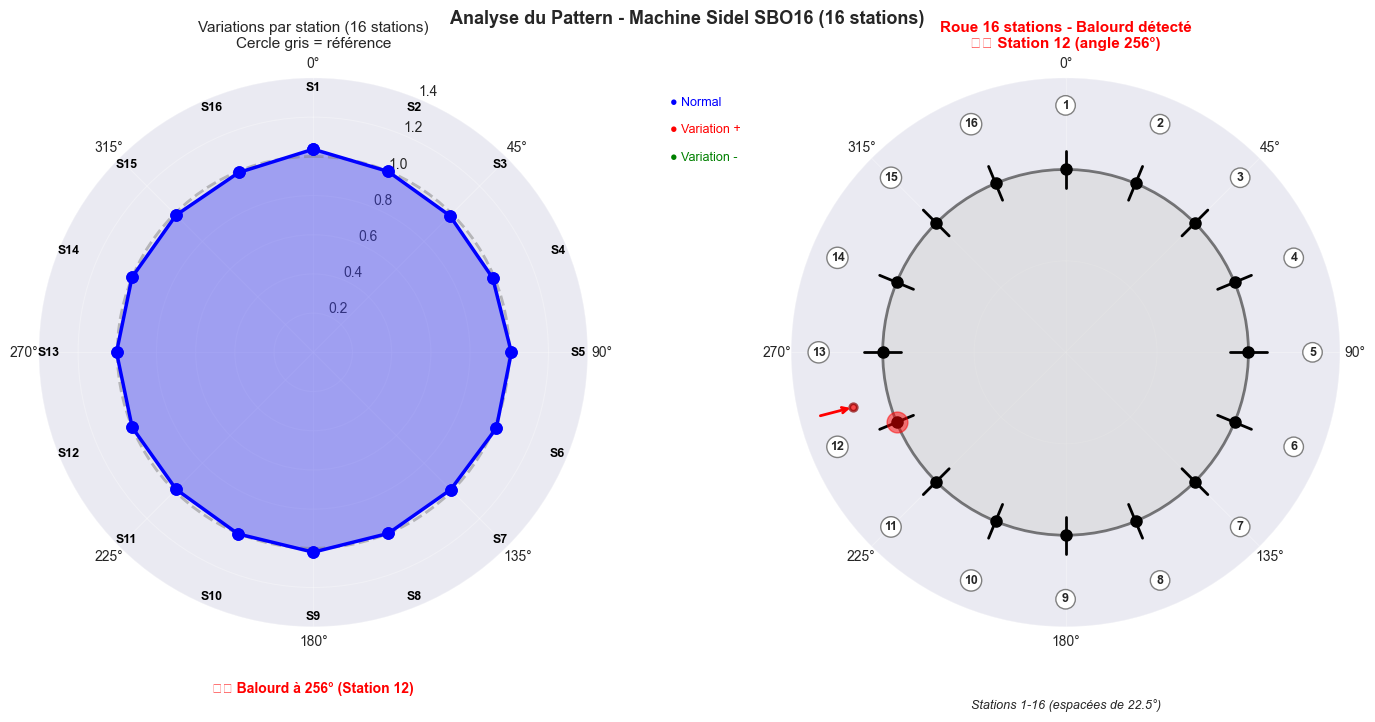


📊 INTERPRÉTATION DU GRAPHIQUE RADAR:
  • Machine configurée: SBO16 avec 16 stations
  • Espacement angulaire: 22.5° entre chaque station
  • Graphique gauche: Une valeur par station (polygone bleu)
  • Cercle gris = référence (pas de variation)
  • Plus le polygone s'éloigne du cercle = plus forte variation

  ⚠️ BALOURD DÉTECTÉ:
     • Position angulaire: 256°
     • Station concernée: Station 12
     • ACTION: Vérifier la Station 12 et son opposée (Station 4)
     • Équilibrage: Ajouter une masse à la Station 4


In [357]:
def analyser_pattern_rotation(df):
    """
    Analyse le pattern de variation sur une rotation complète
    """
    # Normaliser la position sur [0, 360] degrés
    position_norm = df['position_corrigee'].values
    position_deg = ((position_norm - position_norm[0]) % POINTS_PAR_TOUR) / POINTS_PAR_TOUR * 360
    
    # Créer des bins pour moyenner par angle
    n_bins = 360  # 1 bin par degré
    bins = np.linspace(0, 360, n_bins + 1)
    
    # Moyenner les variations par angle
    variation_par_angle = []
    angles = []
    
    for i in range(n_bins):
        mask = (position_deg >= bins[i]) & (position_deg < bins[i+1])
        if np.sum(mask) > 0:
            variation_par_angle.append(df['variation_vitesse'].values[mask].mean())
            angles.append((bins[i] + bins[i+1]) / 2)
    
    variation_par_angle = np.array(variation_par_angle)
    angles = np.array(angles)
    
    # Calcul de l'amplitude de variation
    if len(variation_par_angle) > 0:
        amplitude_pattern = np.max(variation_par_angle) - np.min(variation_par_angle)
        angle_max = angles[np.argmax(variation_par_angle)]
        angle_min = angles[np.argmin(variation_par_angle)]
        
        print(f"\n✓ Analyse du pattern de rotation")
        print(f"  Amplitude du pattern: {amplitude_pattern*100:.3f}%")
        print(f"  Angle de variation max: {angle_max:.1f}°")
        print(f"  Angle de variation min: {angle_min:.1f}°")
        
        # Critère de balourd basé sur le pattern
        balourd_pattern = amplitude_pattern > SEUIL_VARIATION_VITESSE
        
        # Visualisation du pattern avec graphique radar
        visualiser_pattern_radar(angles, variation_par_angle, angle_max, angle_min, balourd_pattern)
        
        return angles, variation_par_angle, balourd_pattern, angle_max
    else:
        print("\n⚠️ Pas assez de données pour analyser le pattern de rotation")
        return None, None, False, None

def visualiser_pattern_radar(angles, variation_par_angle, angle_max, angle_min, balourd_detecte):
    """
    Crée une visualisation radar (polaire) du pattern de rotation
    avec les stations de soufflage comme repères
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), 
                                   subplot_kw=dict(projection='polar', theta_direction=-1, theta_offset=np.pi/2))
    
    # Calcul des positions angulaires des stations
    angles_stations = np.linspace(0, 360, NOMBRE_STATIONS + 1)[:-1]  # Exclure 360° (=0°)
    theta_stations = np.deg2rad(angles_stations)
    
    # === GRAPHIQUE 1: Pattern de variation simplifié ===
    
    # Interpolation pour avoir une valeur par station
    variations_stations = []
    for angle_st in angles_stations:
        # Trouver la variation moyenne autour de cette station (±5°)
        mask = np.abs(angles - angle_st) <= (180 / NOMBRE_STATIONS)
        if np.any(mask):
            variations_stations.append(np.mean(variation_par_angle[mask]))
        else:
            # Interpolation si pas de données
            idx = np.argmin(np.abs(angles - angle_st))
            variations_stations.append(variation_par_angle[idx])
    
    variations_stations = np.array(variations_stations)
    
    # Fermer le polygone pour le graphique
    theta_plot = np.append(theta_stations, theta_stations[0])
    variations_plot = np.append(variations_stations, variations_stations[0])
    
    # Normalisation : convertir les variations en rayon (1 = référence, >1 = variation positive)
    r_stations = 1 + variations_plot * 20  # Amplification pour visibilité
    
    # Tracer le cercle de référence (pas de variation)
    circle_theta = np.linspace(0, 2*np.pi, 100)
    ax1.plot(circle_theta, np.ones_like(circle_theta), 'gray', linestyle='--', linewidth=2, alpha=0.5)
    ax1.fill(circle_theta, np.ones_like(circle_theta), 'lightgray', alpha=0.2)
    
    # Tracer le pattern station par station
    ax1.plot(theta_plot, r_stations, 'b-', linewidth=2.5, marker='o', markersize=8)
    ax1.fill(theta_plot, r_stations, 'blue', alpha=0.3)
    
    # Marquer chaque station
    for i, (theta_st, var_st) in enumerate(zip(theta_stations, variations_stations)):
        r_st = 1 + var_st * 20
        # Colorer différemment les stations avec forte variation
        if abs(var_st) > SEUIL_VARIATION_VITESSE:
            color = 'red' if var_st > 0 else 'green'
            size = 12
        else:
            color = 'blue'
            size = 8
        
        ax1.plot(theta_st, r_st, 'o', color=color, markersize=size)
        
        # Numéro de station à l'extérieur
        ax1.text(theta_st, 1.35, f'S{i+1}', ha='center', va='center', fontsize=9, 
                fontweight='bold', color='black')
    
    # Identifier la station la plus affectée basée sur les variations par station
    if balourd_detecte:
        station_max_variation = np.argmax(abs(variations_stations)) + 1
        variation_max = variations_stations[station_max_variation - 1]
        
        # Trouver la station la plus proche de l'angle du balourd détecté
        station_balourd = np.argmin(np.abs(angles_stations - angle_max)) + 1
        
        # Utiliser la station basée sur l'angle du balourd pour la cohérence
        ax1.text(0.5, -0.12, f'⚠️ Balourd à {angle_max:.0f}° (Station {station_balourd})', 
                transform=ax1.transAxes, ha='center', fontsize=10, color='red', fontweight='bold')
    
    # Configuration du graphique
    ax1.set_ylim(0, 1.4)
    ax1.set_title(f'Variations par station ({NOMBRE_STATIONS} stations)\nCercle gris = référence', 
                 fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Ajout d'une légende
    ax1.text(1.15, 0.95, '● Normal', transform=ax1.transAxes, color='blue', fontsize=9)
    ax1.text(1.15, 0.90, '● Variation +', transform=ax1.transAxes, color='red', fontsize=9)
    ax1.text(1.15, 0.85, '● Variation -', transform=ax1.transAxes, color='green', fontsize=9)
    
    # === GRAPHIQUE 2: Représentation de la roue avec stations ===
    ax2.set_ylim(0, 1.5)
    
    # Dessiner la roue
    ax2.fill(circle_theta, np.ones_like(circle_theta), 'lightgray', alpha=0.5, edgecolor='black', linewidth=2)
    
    # Marquer les stations de soufflage
    for i, (angle_st, theta_st) in enumerate(zip(angles_stations, theta_stations)):
        # Ligne radiale pour chaque station
        ax2.plot([theta_st, theta_st], [0.9, 1.1], 'black', linewidth=2)
        # Point pour chaque station
        ax2.plot(theta_st, 1.0, 'ko', markersize=8)
        # Numéro de station à l'extérieur
        ax2.text(theta_st, 1.35, f'{i+1}', ha='center', va='center', fontsize=9, 
                fontweight='bold', bbox=dict(boxstyle='circle', facecolor='white', edgecolor='gray'))
    
    # Si balourd détecté, ajouter une masse
    if balourd_detecte:
        # Position du balourd
        balourd_theta = np.deg2rad(angle_max)
        
        # Dessiner le balourd comme une masse supplémentaire
        balourd_size = abs(variation_par_angle[np.argmin(np.abs(angles - angle_max))]) * 5000
        ax2.scatter([balourd_theta], [1.2], s=balourd_size, c='red', alpha=0.7, 
                   edgecolors='darkred', linewidth=2)
        
        # Flèche indiquant le balourd
        ax2.annotate('', xy=(balourd_theta, 1.2), xytext=(balourd_theta, 1.4),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2))
        
        # Station affectée
        station_balourd = np.argmin(np.abs(angles_stations - angle_max)) + 1
        angle_station = angles_stations[station_balourd - 1]
        
        titre = f'Roue {NOMBRE_STATIONS} stations - Balourd détecté\n⚠️ Station {station_balourd} (angle {angle_max:.0f}°)'
        couleur_titre = 'red'
        
        # Mettre en évidence la station affectée
        theta_station_balourd = np.deg2rad(angle_station)
        ax2.plot(theta_station_balourd, 1.0, 'ro', markersize=15, alpha=0.5)
    else:
        # Roue équilibrée
        ax2.text(0, 0, '✓', ha='center', va='center', fontsize=40, color='green', fontweight='bold')
        titre = f'Roue {NOMBRE_STATIONS} stations\n✓ Équilibrage correct'
        couleur_titre = 'green'
    
    # Configuration
    ax2.set_title(titre, fontsize=11, color=couleur_titre, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_rticks([0.5, 1, 1.5])
    ax2.set_yticklabels(['', '', ''])
    
    # Légende des stations
    ax2.text(0.5, -0.15, f'Stations 1-{NOMBRE_STATIONS} (espacées de {360/NOMBRE_STATIONS:.1f}°)', 
            transform=ax2.transAxes, ha='center', fontsize=9, style='italic')
    
    plt.suptitle(f'Analyse du Pattern - Machine Sidel SBO{NOMBRE_STATIONS} ({NOMBRE_STATIONS} stations)', 
                fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Interprétation textuelle adaptée aux stations
    print("\n📊 INTERPRÉTATION DU GRAPHIQUE RADAR:")
    print(f"  • Machine configurée: SBO{NOMBRE_STATIONS} avec {NOMBRE_STATIONS} stations")
    print(f"  • Espacement angulaire: {360/NOMBRE_STATIONS:.1f}° entre chaque station")
    print("  • Graphique gauche: Une valeur par station (polygone bleu)")
    print("  • Cercle gris = référence (pas de variation)")
    print("  • Plus le polygone s'éloigne du cercle = plus forte variation")
    
    if balourd_detecte:
        # Utiliser la station basée sur l'angle du balourd pour la cohérence
        station_balourd = np.argmin(np.abs(angles_stations - angle_max)) + 1
        station_opposee = ((station_balourd - 1 + NOMBRE_STATIONS//2) % NOMBRE_STATIONS) + 1
        print(f"\n  ⚠️ BALOURD DÉTECTÉ:")
        print(f"     • Position angulaire: {angle_max:.0f}°")
        print(f"     • Station concernée: Station {station_balourd}")
        print(f"     • ACTION: Vérifier la Station {station_balourd} et son opposée (Station {station_opposee})")
        print(f"     • Équilibrage: Ajouter une masse à la Station {station_opposee}")

angles, variation_par_angle, balourd_pattern, angle_balourd = analyser_pattern_rotation(df)

## 8. Diagnostic final du balourd

In [358]:
def diagnostiquer_balourd(df, balourd_fft, balourd_pattern, amplitude_fft_max=None):
    """
    Effectue le diagnostic final de présence de balourd
    """
    diagnostic = {
        'balourd_detecte': False,
        'confiance': 0,
        'severite': 'Aucune',
        'angle_balourd': angle_balourd if angle_balourd else None,
        'recommandations': []
    }
    
    # Calcul des métriques
    variation_max = df['variation_vitesse'].abs().max()
    variation_std = df['variation_vitesse'].std()
    
    # Critères de détection
    criteres = {
        'variation_vitesse': variation_max > SEUIL_VARIATION_VITESSE,
        'ecart_type_eleve': variation_std > SEUIL_VARIATION_VITESSE / 2,
        'signature_fft': balourd_fft,
        'pattern_rotation': balourd_pattern
    }
    
    # Calcul du score de confiance
    nb_criteres_valides = sum(criteres.values())
    diagnostic['confiance'] = nb_criteres_valides / len(criteres)
    
    # Détermination du balourd
    if nb_criteres_valides >= 2:  # Au moins 2 critères sur 4
        diagnostic['balourd_detecte'] = True
        
        # Évaluation de la sévérité basée sur l'amplitude de variation
        if variation_max > 0.02:  # 2%
            diagnostic['severite'] = 'CRITIQUE'
            diagnostic['recommandations'].append("⚠️ URGENT: Arrêt et équilibrage immédiat recommandé")
            diagnostic['recommandations'].append("📍 Risque de dommages mécaniques")
        elif variation_max > 0.01:  # 1%
            diagnostic['severite'] = 'Élevée'
            diagnostic['recommandations'].append("⚠️ Planifier un équilibrage rapidement")
            diagnostic['recommandations'].append("📊 Surveiller l'évolution quotidiennement")
        elif variation_max > 0.005:  # 0.5%
            diagnostic['severite'] = 'Modérée'
            diagnostic['recommandations'].append("ℹ️ Balourd détecté mais acceptable temporairement")
            diagnostic['recommandations'].append("📅 Prévoir un équilibrage lors de la prochaine maintenance")
        else:
            diagnostic['severite'] = 'Faible'
            diagnostic['recommandations'].append("ℹ️ Balourd léger détecté")
            diagnostic['recommandations'].append("👁️ Surveiller l'évolution mensuellement")
        
        if diagnostic['angle_balourd'] is not None:
            diagnostic['recommandations'].append(f"🎯 Position du balourd: {diagnostic['angle_balourd']:.0f}°")
    else:
        diagnostic['recommandations'].append("✅ Aucun balourd significatif détecté")
        diagnostic['recommandations'].append("ℹ️ Continuer la surveillance périodique")
        diagnostic['recommandations'].append("📈 Les variations observées sont dans les limites normales")
    
    # Affichage du diagnostic
    print("\n" + "="*60)
    print("DIAGNOSTIC FINAL")
    print("="*60)
    print(f"🔍 Balourd détecté: {'OUI' if diagnostic['balourd_detecte'] else 'NON'}")
    print(f"📊 Niveau de confiance: {diagnostic['confiance']:.0%}")
    print(f"⚡ Sévérité: {diagnostic['severite']}")
    print(f"\n📈 Métriques clés:")
    print(f"  • Variation maximale: {variation_max*100:.3f}%")
    print(f"  • Écart-type: {variation_std*100:.3f}%")
    print(f"\n📋 Détail des critères:")
    for critere, valide in criteres.items():
        print(f"  {'✓' if valide else '✗'} {critere}: {'Validé' if valide else 'Non validé'}")
    print(f"\n💡 Recommandations:")
    for recommandation in diagnostic['recommandations']:
        print(f"  {recommandation}")
    
    return diagnostic

diagnostic = diagnostiquer_balourd(df, balourd_fft, balourd_pattern if angles is not None else False)


DIAGNOSTIC FINAL
🔍 Balourd détecté: OUI
📊 Niveau de confiance: 50%
⚡ Sévérité: Élevée

📈 Métriques clés:
  • Variation maximale: 1.319%
  • Écart-type: 0.242%

📋 Détail des critères:
  ✓ variation_vitesse: Validé
  ✗ ecart_type_eleve: Non validé
  ✗ signature_fft: Non validé
  ✓ pattern_rotation: Validé

💡 Recommandations:
  ⚠️ Planifier un équilibrage rapidement
  📊 Surveiller l'évolution quotidiennement
  🎯 Position du balourd: 256°


## 9. Visualisation complète des résultats

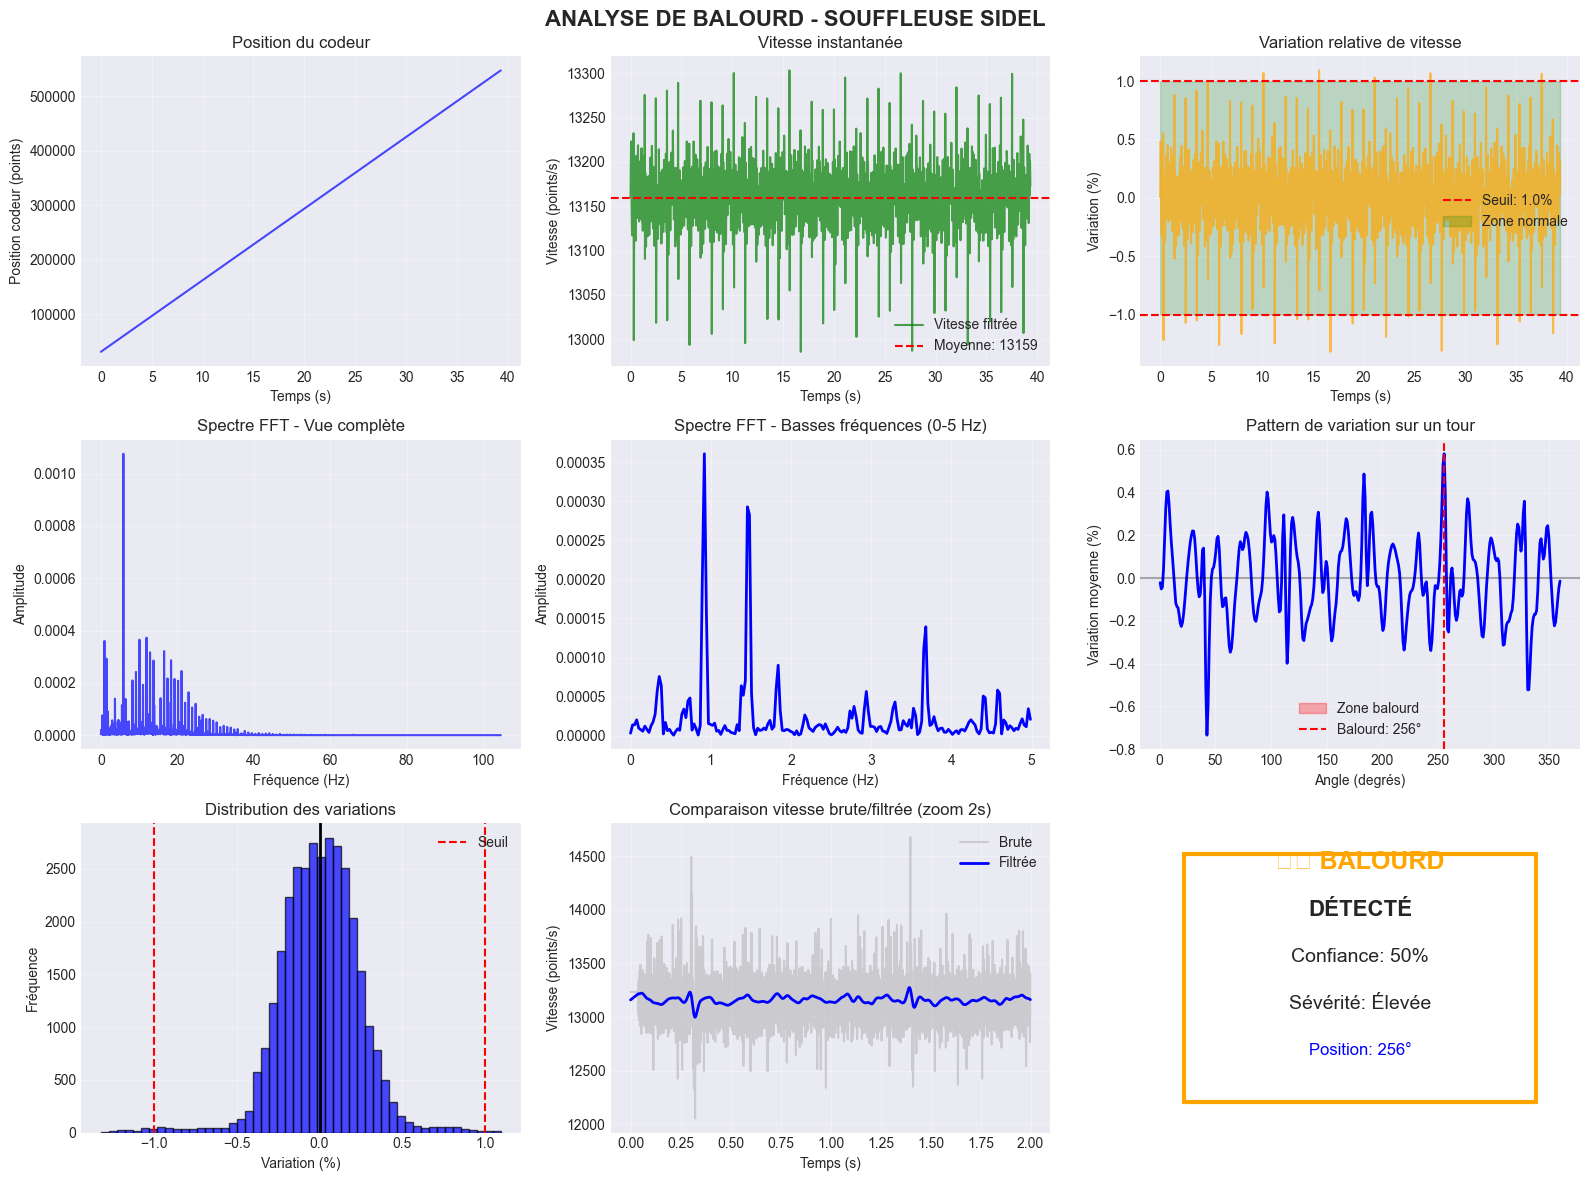

In [359]:
def visualiser_resultats_complets(df, frequencies, amplitudes, peaks, 
                                  angles, variation_par_angle, diagnostic):
    """
    Crée une visualisation complète des résultats d'analyse
    """
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Position du codeur dans le temps
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(df['temps'], df['position_corrigee'], 'b-', alpha=0.7)
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Position codeur (points)')
    ax1.set_title('Position du codeur')
    ax1.grid(True, alpha=0.3)
    
    # 2. Vitesse instantanée
    ax2 = plt.subplot(3, 3, 2)
    ax2.plot(df['temps'], df['vitesse_filtree'], 'g-', alpha=0.7, label='Vitesse filtrée')
    ax2.axhline(y=df['vitesse_filtree'].mean(), color='r', linestyle='--', 
                label=f'Moyenne: {df["vitesse_filtree"].mean():.0f}')
    ax2.set_xlabel('Temps (s)')
    ax2.set_ylabel('Vitesse (points/s)')
    ax2.set_title('Vitesse instantanée')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Variation de vitesse (%)
    ax3 = plt.subplot(3, 3, 3)
    ax3.plot(df['temps'], df['variation_vitesse']*100, 'orange', alpha=0.7)
    ax3.axhline(y=SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--', 
                label=f'Seuil: {SEUIL_VARIATION_VITESSE*100:.1f}%')
    ax3.axhline(y=-SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--')
    ax3.fill_between(df['temps'], -SEUIL_VARIATION_VITESSE*100, SEUIL_VARIATION_VITESSE*100, 
                     alpha=0.2, color='green', label='Zone normale')
    ax3.set_xlabel('Temps (s)')
    ax3.set_ylabel('Variation (%)')
    ax3.set_title('Variation relative de vitesse')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Spectre FFT complet
    ax4 = plt.subplot(3, 3, 4)
    ax4.plot(frequencies[:len(frequencies)//4], amplitudes[:len(frequencies)//4], 'b-', alpha=0.7)
    if len(peaks) > 0:
        ax4.plot(frequencies[peaks], amplitudes[peaks], 'ro', markersize=8, label='Pics détectés')
    ax4.set_xlabel('Fréquence (Hz)')
    ax4.set_ylabel('Amplitude')
    ax4.set_title('Spectre FFT - Vue complète')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Spectre FFT zoom basses fréquences
    ax5 = plt.subplot(3, 3, 5)
    mask_bf = frequencies < 5  # Zoom sur 0-5 Hz
    ax5.plot(frequencies[mask_bf], amplitudes[mask_bf], 'b-', linewidth=2)
    peaks_bf = peaks[peaks < np.sum(mask_bf)]
    if len(peaks_bf) > 0:
        ax5.plot(frequencies[peaks_bf], amplitudes[peaks_bf], 'ro', markersize=10)
        for peak in peaks_bf[:3]:  # Annoter les 3 premiers pics
            ax5.annotate(f'{frequencies[peak]:.2f} Hz', 
                        xy=(frequencies[peak], amplitudes[peak]),
                        xytext=(10, 10), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))
    ax5.set_xlabel('Fréquence (Hz)')
    ax5.set_ylabel('Amplitude')
    ax5.set_title('Spectre FFT - Basses fréquences (0-5 Hz)')
    ax5.grid(True, alpha=0.3)
    
    # 6. Pattern de variation par angle
    ax6 = plt.subplot(3, 3, 6)
    if angles is not None and variation_par_angle is not None:
        ax6.plot(angles, variation_par_angle*100, 'b-', linewidth=2)
        ax6.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax6.fill_between(angles, 0, variation_par_angle*100, 
                         where=(variation_par_angle*100 > SEUIL_VARIATION_VITESSE*100), 
                         color='red', alpha=0.3, label='Zone balourd')
        if diagnostic['angle_balourd']:
            ax6.axvline(x=diagnostic['angle_balourd'], color='red', linestyle='--', 
                       label=f'Balourd: {diagnostic["angle_balourd"]:.0f}°')
        ax6.set_xlabel('Angle (degrés)')
        ax6.set_ylabel('Variation moyenne (%)')
        ax6.set_title('Pattern de variation sur un tour')
        ax6.legend()
    else:
        ax6.text(0.5, 0.5, 'Données insuffisantes\npour le pattern', 
                ha='center', va='center', fontsize=12)
    ax6.grid(True, alpha=0.3)
    
    # 7. Histogramme des variations
    ax7 = plt.subplot(3, 3, 7)
    ax7.hist(df['variation_vitesse']*100, bins=50, color='blue', alpha=0.7, edgecolor='black')
    ax7.axvline(x=0, color='k', linestyle='-', linewidth=2)
    ax7.axvline(x=SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--', label='Seuil')
    ax7.axvline(x=-SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--')
    ax7.set_xlabel('Variation (%)')
    ax7.set_ylabel('Fréquence')
    ax7.set_title('Distribution des variations')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Vitesse brute vs filtrée (zoom)
    ax8 = plt.subplot(3, 3, 8)
    # Zoom sur les 2 premières secondes
    mask_zoom = df['temps'] < 2
    ax8.plot(df['temps'][mask_zoom], df['vitesse_brute'][mask_zoom], 
            'gray', alpha=0.3, label='Brute')
    ax8.plot(df['temps'][mask_zoom], df['vitesse_filtree'][mask_zoom], 
            'b-', linewidth=2, label='Filtrée')
    ax8.set_xlabel('Temps (s)')
    ax8.set_ylabel('Vitesse (points/s)')
    ax8.set_title('Comparaison vitesse brute/filtrée (zoom 2s)')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # 9. Diagnostic visuel
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    # Création d'un indicateur visuel
    if diagnostic['balourd_detecte']:
        if diagnostic['severite'] == 'CRITIQUE':
            couleur = 'red'
            symbole = '⚠️'
        elif diagnostic['severite'] == 'Élevée':
            couleur = 'orange'
            symbole = '⚠️'
        else:
            couleur = 'yellow'
            symbole = '⚡'
    else:
        couleur = 'green'
        symbole = '✓'
    
    # Affichage du diagnostic
    ax9.text(0.5, 0.85, f"{symbole} BALOURD", 
             fontsize=18, fontweight='bold', color=couleur, ha='center')
    ax9.text(0.5, 0.70, f"{'DÉTECTÉ' if diagnostic['balourd_detecte'] else 'NON DÉTECTÉ'}", 
             fontsize=16, fontweight='bold', ha='center')
    ax9.text(0.5, 0.55, f"Confiance: {diagnostic['confiance']:.0%}", 
             fontsize=14, ha='center')
    ax9.text(0.5, 0.40, f"Sévérité: {diagnostic['severite']}", 
             fontsize=14, ha='center')
    
    if diagnostic['angle_balourd'] is not None:
        ax9.text(0.5, 0.25, f"Position: {diagnostic['angle_balourd']:.0f}°", 
                fontsize=12, ha='center', color='blue')
    
    # Cadre autour du diagnostic
    rect = plt.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=3, 
                         edgecolor=couleur, facecolor='none')
    ax9.add_patch(rect)
    
    plt.suptitle('ANALYSE DE BALOURD - SOUFFLEUSE SIDEL', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Affichage de la visualisation
visualiser_resultats_complets(df, frequencies, amplitudes, peaks, 
                             angles, variation_par_angle, diagnostic)

## 10. Export des résultats détaillés

In [360]:
def exporter_resultats_detailles(df, diagnostic, frequencies, amplitudes, peaks, 
                                 angles, variation_par_angle, 
                                 nom_fichier='resultats_balourd_sidel.xlsx'):
    """
    Exporte les résultats détaillés de l'analyse dans un fichier Excel
    """
    try:
        with pd.ExcelWriter(nom_fichier, engine='openpyxl') as writer:
            # Feuille 1: Données principales
            df_export = df[['temps', 'position_codeur', 'position_corrigee', 
                          'vitesse_filtree', 'variation_vitesse']].copy()
            df_export['variation_pourcent'] = df_export['variation_vitesse'] * 100
            df_export.to_excel(writer, sheet_name='Données', index=False, float_format='%.6f')
            
            # Feuille 2: Diagnostic
            df_diagnostic = pd.DataFrame({
                'Paramètre': [
                    'Balourd détecté',
                    'Niveau de confiance',
                    'Sévérité',
                    'Variation maximale (%)',
                    'Écart-type variation (%)',
                    'Angle du balourd (°)',
                    'Vitesse moyenne (points/s)',
                    'Nombre de points analysés',
                    'Durée totale (s)',
                    'Tours effectués'
                ],
                'Valeur': [
                    'OUI' if diagnostic['balourd_detecte'] else 'NON',
                    f"{diagnostic['confiance']:.0%}",
                    diagnostic['severite'],
                    f"{df['variation_vitesse'].abs().max()*100:.3f}",
                    f"{df['variation_vitesse'].std()*100:.3f}",
                    f"{diagnostic['angle_balourd']:.1f}" if diagnostic['angle_balourd'] else 'N/A',
                    f"{df['vitesse_filtree'].mean():.1f}",
                    len(df),
                    f"{df['temps'].iloc[-1] - df['temps'].iloc[0]:.3f}",
                    f"{(df['position_corrigee'].iloc[-1] - df['position_corrigee'].iloc[0]) / POINTS_PAR_TOUR:.2f}"
                ]
            })
            df_diagnostic.to_excel(writer, sheet_name='Diagnostic', index=False)
            
            # Feuille 3: Analyse FFT
            if len(peaks) > 0:
                df_fft = pd.DataFrame({
                    'Fréquence (Hz)': frequencies[peaks],
                    'Amplitude': amplitudes[peaks]
                })
                df_fft = df_fft.sort_values('Amplitude', ascending=False)
                df_fft.to_excel(writer, sheet_name='Pics_FFT', index=False, float_format='%.6f')
            
            # Feuille 4: Pattern angulaire
            if angles is not None and variation_par_angle is not None:
                df_pattern = pd.DataFrame({
                    'Angle (deg)': angles,
                    'Variation moyenne (%)': variation_par_angle * 100
                })
                df_pattern.to_excel(writer, sheet_name='Pattern_angulaire', index=False, float_format='%.3f')
            
            # Feuille 5: Recommandations
            df_recommandations = pd.DataFrame({
                'Recommandations': diagnostic['recommandations']
            })
            df_recommandations.to_excel(writer, sheet_name='Recommandations', index=False)
        
        print(f"\n✅ Résultats exportés dans '{nom_fichier}'")
        return True
    
    except Exception as e:
        print(f"\n❌ Erreur lors de l'export: {e}")
        return False

# Export des résultats
exporter_resultats_detailles(df, diagnostic, frequencies, amplitudes, peaks, 
                            angles, variation_par_angle)


❌ Erreur lors de l'export: No module named 'openpyxl'


False